In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
file_path = "202501.xlsx"
df = pd.read_excel(file_path, sheet_name='202501')

In [17]:
# 금속 농도 열과 측정시간 열만 선택

metal_columns = [col for col in df.columns if '(ng/m3)' in col]
df_metal = df[['Pump-Begin'] + metal_columns].copy()

print(df_metal.head(10))

           Pump-Begin  Al(ng/m3)  Si(ng/m3)  S(ng/m3)  K(ng/m3)  Ca(ng/m3)  \
0 2025-01-10 10:53:43        NaN        NaN       NaN       NaN        NaN   
1 2025-01-10 12:00:00     793.97     834.70   2338.79    358.10     155.00   
2 2025-01-10 13:00:00    1004.34     727.61   1361.91    281.32     124.75   
3 2025-01-10 14:00:01     477.28     687.55   1387.49    267.52     128.43   
4 2025-01-10 15:00:00     465.45     717.28   1441.36    266.17     138.57   
5 2025-01-10 16:00:00     429.06     705.10   1999.81    238.93     134.96   
6 2025-01-10 17:00:00     525.07     763.88   2394.23    247.71     126.84   
7 2025-01-10 18:00:01     437.81     759.28   2387.05    245.92     134.89   
8 2025-01-10 19:00:00     449.52     782.00   2499.57    255.90     120.53   
9 2025-01-10 20:00:01     473.71     797.64   2612.50    250.55     120.05   

   Ti(ng/m3)  V(ng/m3)  Cr(ng/m3)  Mn(ng/m3)  ...  Cd(ng/m3)  In(ng/m3)  \
0        NaN       NaN        NaN        NaN  ...        NaN      

In [19]:
# 날짜 변환 및 날짜 열 생성

df_metal['Pump-Begin'] = pd.to_datetime(df_metal['Pump-Begin'])
df_metal['Date'] = df_metal['Pump-Begin'].dt.date

print(df_metal[['Pump-Begin', 'Date']].head(10))

           Pump-Begin        Date
0 2025-01-10 10:53:43  2025-01-10
1 2025-01-10 12:00:00  2025-01-10
2 2025-01-10 13:00:00  2025-01-10
3 2025-01-10 14:00:01  2025-01-10
4 2025-01-10 15:00:00  2025-01-10
5 2025-01-10 16:00:00  2025-01-10
6 2025-01-10 17:00:00  2025-01-10
7 2025-01-10 18:00:01  2025-01-10
8 2025-01-10 19:00:00  2025-01-10
9 2025-01-10 20:00:01  2025-01-10


In [20]:
# 이상치 제거: 음수, 0, NaN / 모두 결측 처리

for col in metal_columns:
    df_filtered[col] = df_filtered[col].apply(lambda x: x if pd.notna(x) and x > 0 else pd.NA)

df_filtered_with_na = df_filtered[df_filtered[metal_columns].isna().any(axis=1)]
print(df_filtered_with_na.head())

           Pump-Begin Al(ng/m3) Si(ng/m3) S(ng/m3) K(ng/m3) Ca(ng/m3)  \
0 2025-01-10 10:53:43      <NA>      <NA>     <NA>     <NA>      <NA>   
1 2025-01-10 12:00:00    793.97     834.7  2338.79    358.1     155.0   
2 2025-01-10 13:00:00   1004.34    727.61  1361.91   281.32    124.75   
3 2025-01-10 14:00:01    477.28    687.55  1387.49   267.52    128.43   
4 2025-01-10 15:00:00    465.45    717.28  1441.36   266.17    138.57   

  Ti(ng/m3) V(ng/m3) Cr(ng/m3) Mn(ng/m3)  ... In(ng/m3) Sn(ng/m3) Sb(ng/m3)  \
0      <NA>     <NA>      <NA>      <NA>  ...      <NA>      <NA>      <NA>   
1      0.75     4.35      6.11     10.28  ...     57.61     30.11     29.99   
2      0.59     4.63      7.26      9.74  ...     69.71     47.75      <NA>   
3      <NA>     4.04      5.53      8.61  ...     54.34      6.92     28.12   
4      0.28     4.62      6.43     10.07  ...     55.92      23.7     24.88   

  Te(ng/m3) Cs(ng/m3) Ba(ng/m3) Ce(ng/m3) Pb(ng/m3) Bi(ng/m3)        Date  
0      <NA

In [21]:
# 일별 평균 금속 농도 계산

df_daily_avg = df_filtered.groupby('Date')[metal_columns].mean().reset_index()

print(df_daily_avg.head(10))

         Date   Al(ng/m3)    Si(ng/m3)     S(ng/m3)    K(ng/m3)   Ca(ng/m3)  \
0  2025-01-10  538.973333   760.786667  2219.214167  264.145833  129.110833   
1  2025-01-11  452.053333   747.914583  3660.784583   233.24125  112.280417   
2  2025-01-12  462.824583   817.724583   3892.74375     266.025      126.24   
3  2025-01-13   542.69375  1117.748333  4561.004167   281.33375  135.499583   
4  2025-01-14  727.442083  2117.083333    5536.2075    382.1625   205.36125   
5  2025-01-15  490.218333  1102.818333  3459.442083   245.89375    136.5875   
6  2025-01-16  425.190833   824.305833     2879.425    233.9775  131.075833   
7  2025-01-17  570.197083  1089.860833  4456.847917  320.781667  148.820417   
8  2025-01-18   601.19625  1169.575833  5253.412917  342.493333      157.23   
9  2025-01-19  311.262083   841.845833  2556.003333     186.825      110.95   

  Ti(ng/m3)  V(ng/m3) Cr(ng/m3)  Mn(ng/m3)  ...   Cd(ng/m3)  In(ng/m3)  \
0  0.496364  4.210833  6.108333   9.438333  ...  321.519

In [22]:
import matplotlib.pyplot as plt

# 날짜를 문자열로 변환 (시각화 시 x축이 깨지는 것 방지)
df_daily_avg['Date'] = df_daily_avg['Date'].astype(str)

/tmp/ipython-input-45-4163029231.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bottom += values.fillna(0)  # 결측치 0으로 처리하여 누적


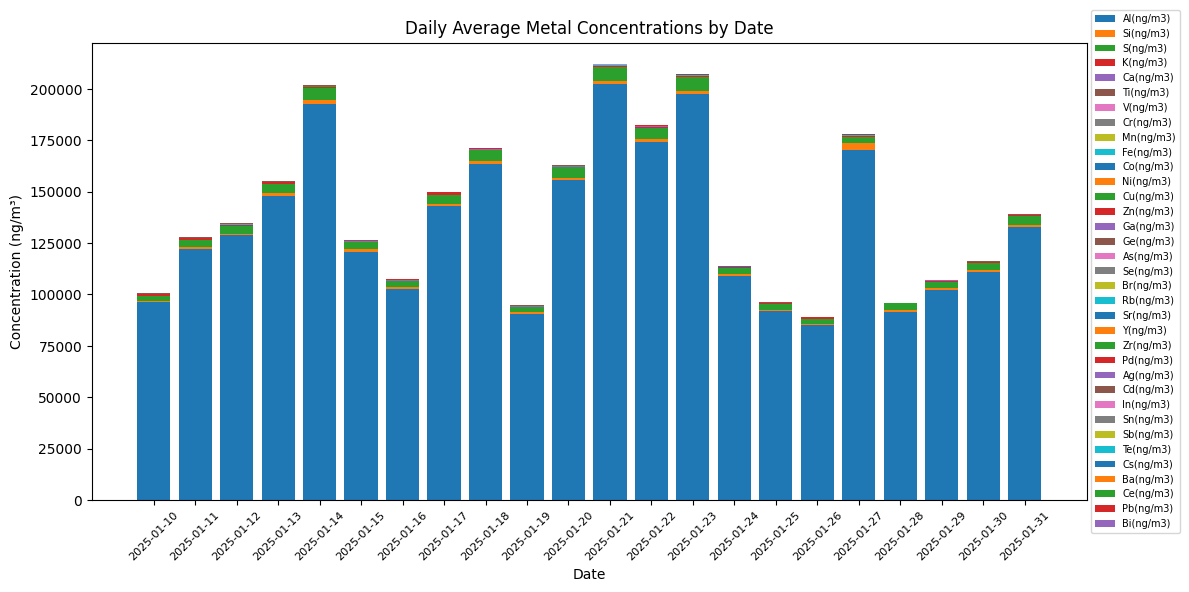

In [45]:
# 누적 막대그래프 시각화
plt.figure(figsize=(12, 6))  # 가로 세로 크기 조절

bottom = None # 누적값 초기화 기준선 0
for i, metal in enumerate(metal_columns): #금속 원소 리스트 순회하며 꺼냄
    values = df_daily_avg[metal]
    if i == 0:
        bottom = None
        plt.bar(df_daily_avg['Date'], values, label=metal) # 첫 금속 막대 그리기
        bottom = values
    else:
        plt.bar(df_daily_avg['Date'], values, bottom=bottom, label=metal) # 두번째 금속부터 누적 농도 위에 값 쌓음
        bottom += values.fillna(0)  # 결측치 0으로 처리하여 누적

# 그래프 세부 설정
plt.title("Daily Average Metal Concentrations by Date")
plt.xticks(rotation=45, fontsize=8)
plt.xlabel("Date")
plt.ylabel("Concentration (ng/m³)")
# 범례 설정
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7, ncol=1)
# 자동정렬
plt.tight_layout()
 # 그래프 출력
plt.show()